In [2]:
! wget https://www.economia-sniim.gob.mx/SNIIM-Archivosfuente/Comentarios/Otros/Leche25072025.xlsx -O milk_prices.xlsx

--2025-07-25 14:00:48--  https://www.economia-sniim.gob.mx/SNIIM-Archivosfuente/Comentarios/Otros/Leche25072025.xlsx
Resolving www.economia-sniim.gob.mx (www.economia-sniim.gob.mx)... 187.217.44.178
Connecting to www.economia-sniim.gob.mx (www.economia-sniim.gob.mx)|187.217.44.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 837018 (817K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘milk_prices.xlsx’

milk_prices.xlsx    100%[===================>] 817.40K   169KB/s    in 4.8s    

2025-07-25 14:00:56 (169 KB/s) - ‘milk_prices.xlsx’ saved [837018/837018]



In [2]:
import pandas as pd
import re

# Path to your Excel file
archivo = "milk_prices.xlsx"  # <-- change this to your actual path

# Dictionary to translate Spanish months to English
meses_es_a_en = {
    'enero': 'January', 'febrero': 'February', 'marzo': 'March',
    'abril': 'April', 'mayo': 'May', 'junio': 'June',
    'julio': 'July', 'agosto': 'August', 'septiembre': 'September',
    'octubre': 'October', 'noviembre': 'November', 'diciembre': 'December'
}

# Read the entire Excel file without headers
df = pd.read_excel(archivo, header=None)

data_final = []

# Search for all relevant blocks
for i, row in df.iterrows():
    if row.astype(str).str.contains("Precio promedio al consumidor por litro", case=False, na=False).any():
        
        # Read the date in the next row
        row_fecha = df.iloc[i + 1]
        fecha_raw = next((str(cell) for cell in row_fecha if isinstance(cell, str) and "de" in cell), None)
        if not fecha_raw:
            continue

        # Extract date components using regex
        match = re.search(r"(\d{1,2}) de (\w+) de (\d{4})", fecha_raw, re.IGNORECASE)
        if not match:
            continue
        dia, mes, año = match.groups()
        mes_en = meses_es_a_en.get(mes.lower())
        if not mes_en:
            continue
        fecha = pd.to_datetime(f"{dia} {mes_en} {año}", dayfirst=True).date()

        # Read combined headers
        enc2 = df.iloc[i + 3, 2:6].values  # Stores, Supermarkets, Stores, Supermarkets
        columnas = ["Estado", "Ciudad"]
        for j in range(4):
            tipo = "Pasteurizada" if j < 2 else "Ultrapasteurizada"
            canal = enc2[j]
            columnas.append(f"{tipo}_{canal}")

        # Read data starting from row i+4
        df_bloque = df.iloc[i + 4:, 0:6].copy()
        df_bloque.columns = columnas

        # Forward fill merged values in Estado and Ciudad
        df_bloque[['Estado', 'Ciudad']] = df_bloque[['Estado', 'Ciudad']].ffill()

        # Stop when reaching "Promedio aritmético" or an empty row
        stop_idx = None
        for k, row_k in df_bloque.iterrows():
            celda = str(row_k[0]).strip().lower()
            if (
                "promedio" in celda
                or "fuente" in celda
                or "sniim" in celda
                or "estado" == celda
                or celda == "nan"
            ):
                stop_idx = k
                break

        if stop_idx:
            df_bloque = df_bloque.loc[:stop_idx - 1]

        # Add date and convert to long format
        df_bloque["Fecha"] = fecha
        df_long = df_bloque.melt(id_vars=["Fecha", "Estado", "Ciudad"],
                                 var_name="Tipo_Canal", value_name="Precio")

        df_long["Tipo"] = df_long["Tipo_Canal"].str.split("_").str[0]
        df_long["Canal"] = df_long["Tipo_Canal"].str.split("_").str[1]
        df_long = df_long[["Fecha", "Estado", "Ciudad", "Tipo", "Canal", "Precio"]]

        data_final.append(df_long)

# Concatenate all blocks
df_final = pd.concat(data_final, ignore_index=True)

# Optional: convert "N.d." to NaN
df_final["Precio"] = pd.to_numeric(df_final["Precio"], errors="coerce")

# Save to CSV
df_final.to_csv("milk_prices_tabular.csv", index=False)

print("✅ Done! File exported as historial_leche_tabular.csv")


/tmp/ipykernel_13401/3339371735.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  celda = str(row_k[0]).strip().lower()
/tmp/ipykernel_13401/3339371735.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  celda = str(row_k[0]).strip().lower()
/tmp/ipykernel_13401/3339371735.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  celda = str(row_k[0]).strip().lower()
/tmp/ipykernel_13401/3339371735.py:58: FutureWarning: Series.__geti

✅ Done! File exported as historial_leche_tabular.csv


In [2]:
import pandas as pd
milk_df = pd.read_csv('milk_prices_tabular.csv', parse_dates=["Fecha"])

In [10]:
milk_df

,Fecha,Estado,Ciudad,Tipo,Canal,Precio
0,2025-07-25,Aguascalientes,Aguascalientes,Pasteurizada,Tiendas,27.400000
1,2025-07-25,Baja California,Mexicali,Pasteurizada,Tiendas,29.300000
2,2025-07-25,Baja California,Tijuana,Pasteurizada,Tiendas,NaN
3,2025-07-25,Baja California Sur,La Paz,Pasteurizada,Tiendas,26.000000
4,2025-07-25,Campeche,Campeche,Pasteurizada,Tiendas,NaN
...,...,...,...,...,...,...
51963,2024-01-03,Veracruz,Veracruz,Ultrapasteurizada,Autoservicios,26.400000
51964,2024-01-03,Yucatán,Mérida,Ultrapasteurizada,Autoservicios,28.080000
51965,2024-01-03,Zacatecas,Zacatecas,Ultrapasteurizada,Autoservicios,29.670000
51966,2024-01-03,Zacatecas,Promedio aritmético,Ultrapasteurizada,Autoservicios,27.522264


In [11]:
milk_df.dtypes

Fecha     datetime64[ns]
Estado            object
Ciudad            object
Tipo              object
Canal             object
Precio           float64
dtype: object

In [12]:
milk_df.isnull().sum()

Fecha        0
Estado       0
Ciudad       0
Tipo         0
Canal        0
Precio    6268
dtype: int64

In [14]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = milk_df.dropna(subset=["Precio"])  # Remove rows with missing target

# Categorical and numerical features
categorical = ["Estado", "Ciudad", "Tipo", "Canal"]
numerical = []  # You can add engineered features later if needed

# Ensure all categorical columns are strings
df[categorical] = df[categorical].astype(str)

# Convert to dictionaries for DictVectorizer
feature_dicts = df[categorical + numerical].to_dict(orient="records")

# One-hot encode
dv = DictVectorizer()
X = dv.fit_transform(feature_dicts)

# Target variable
y = df["Precio"].values

# Initialize model (choose one)
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = XGBRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X, y)

# Predict on training data
y_pred = model.predict(X)

# Evaluate
rmse = root_mean_squared_error(y, y_pred)
print(f"✅ RMSE on training data: {rmse:.4f}")


/tmp/ipykernel_13401/4215871587.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


✅ RMSE on training data: 1.6169


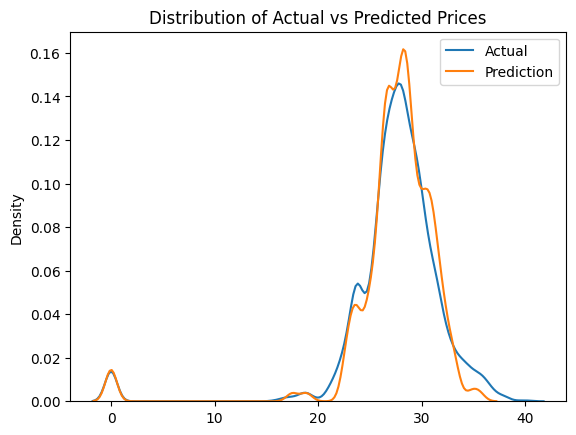

In [15]:
sns.kdeplot(y, label="Actual")
sns.kdeplot(y_pred, label="Prediction")
plt.title("Distribution of Actual vs Predicted Prices")
plt.legend()
plt.show()


In [16]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = milk_df.dropna(subset=["Precio"])  # Remove rows with missing target

# Categorical and numerical features
categorical = ["Estado", "Ciudad", "Tipo", "Canal"]
numerical = []  # You can add engineered features later if needed

# Ensure all categorical columns are strings
df[categorical] = df[categorical].astype(str)

# Convert to dictionaries for DictVectorizer
feature_dicts = df[categorical + numerical].to_dict(orient="records")

# One-hot encode
dv = DictVectorizer()
X = dv.fit_transform(feature_dicts)

# Target variable
y = df["Precio"].values

# Initialize model (choose one)
model = RandomForestRegressor(n_estimators=100, random_state=42)
# model = XGBRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X, y)

# Predict on training data
y_pred = model.predict(X)

# Evaluate
rmse = root_mean_squared_error(y, y_pred)
print(f"✅ RMSE on training data: {rmse:.4f}")

/tmp/ipykernel_13401/307410273.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


✅ RMSE on training data: 1.6157


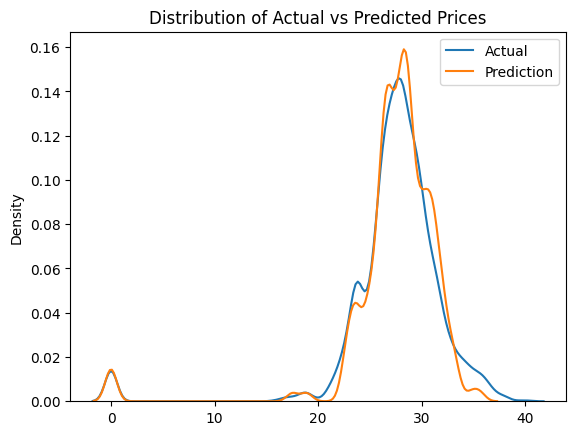

In [17]:
sns.kdeplot(y, label="Actual")
sns.kdeplot(y_pred, label="Prediction")
plt.title("Distribution of Actual vs Predicted Prices")
plt.legend()
plt.show()


In [18]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 182800 stored elements and shape (45700, 92)>

In [20]:
dv.get_feature_names_out()

array(['Canal=Autoservicios', 'Canal=Tiendas', 'Ciudad=Acapulco',
       'Ciudad=Aguascalientes', 'Ciudad=Campeche', 'Ciudad=Cancún',
       'Ciudad=Cd. Obregón', 'Ciudad=Cd. Victoria', 'Ciudad=Cd.Juárez',
       'Ciudad=Celaya', 'Ciudad=Chetumal', 'Ciudad=Chihuahua',
       'Ciudad=Chilpancingo', 'Ciudad=Ciudad de México',
       'Ciudad=Coatzacoalcos', 'Ciudad=Colima', 'Ciudad=Cuernavaca',
       'Ciudad=Culiacán', 'Ciudad=Durango', 'Ciudad=Guadalajara',
       'Ciudad=Gómez Palacio', 'Ciudad=Hermosillo', 'Ciudad=La Paz',
       'Ciudad=León', 'Ciudad=Matamoros', 'Ciudad=Mexicali',
       'Ciudad=Monterrey', 'Ciudad=Morelia', 'Ciudad=Mérida',
       'Ciudad=Nogales', 'Ciudad=Nuevo Laredo', 'Ciudad=Oaxaca',
       'Ciudad=Pachuca', 'Ciudad=Piedras Negras',
       'Ciudad=Promedio Ponderado por Población',
       'Ciudad=Promedio aritmético', 'Ciudad=Puebla', 'Ciudad=Querétaro',
       'Ciudad=Reynosa', 'Ciudad=Saltillo', 'Ciudad=San Luis Potosí',
       'Ciudad=San Luis Río Colorado',

In [21]:
pd.Series(dv.get_feature_names_out())


0        Canal=Autoservicios
1              Canal=Tiendas
2            Ciudad=Acapulco
3      Ciudad=Aguascalientes
4            Ciudad=Campeche
               ...          
87           Estado=Veracruz
88            Estado=Yucatán
89          Estado=Zacatecas
90         Tipo=Pasteurizada
91    Tipo=Ultrapasteurizada
Length: 92, dtype: object

In [4]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = milk_df.dropna(subset=["Precio"])  # Remove rows with missing target

# Define features
categorical = ["Estado", "Ciudad", "Tipo", "Canal"]
numerical = []  # Add engineered features here if needed
df[categorical] = df[categorical].astype(str)

# Encode features
feature_dicts = df[categorical + numerical].to_dict(orient="records")
dv = DictVectorizer()
X = dv.fit_transform(feature_dicts)
y = df["Precio"].values

# Define the objective function for Hyperopt
def objective(params):
    model = XGBRegressor(
        max_depth=int(params["max_depth"]),
        learning_rate=params["learning_rate"],
        n_estimators=int(params["n_estimators"]),
        min_child_weight=params["min_child_weight"],
        gamma=params["gamma"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        random_state=42,
        n_jobs=-1
    )
    # Negative RMSE for hyperopt minimization
    score = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=3)
    return {"loss": -score.mean(), "status": STATUS_OK}

# Define the search space
search_space = {
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", -4, 0),  # ~[0.018, 1]
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

# Run optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=trials,
)

print("✅ Best hyperparameters:")
print(best)

# Retrain final model with best parameters
best_model = XGBRegressor(
    max_depth=int(best["max_depth"]),
    learning_rate=best["learning_rate"],
    n_estimators=int(best["n_estimators"]),
    min_child_weight=best["min_child_weight"],
    gamma=best["gamma"],
    subsample=best["subsample"],
    colsample_bytree=best["colsample_bytree"],
    random_state=42,
    n_jobs=-1
)
best_model.fit(X, y)

# Predict and evaluate on training data (since we didn’t do a holdout set)
y_pred = best_model.predict(X)
rmse = root_mean_squared_error(y, y_pred)
print(f"✅ RMSE on full training data: {rmse:.4f}")


/tmp/ipykernel_25697/3417378392.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


100%|██████████| 25/25 [00:08<00:00,  3.05trial/s, best loss: 2.1141965624200214]
✅ Best hyperparameters:
{'colsample_bytree': np.float64(0.5952390963244428), 'gamma': np.float64(0.8794498653943603), 'learning_rate': np.float64(0.28356349614894566), 'max_depth': np.float64(7.0), 'min_child_weight': np.float64(10.0), 'n_estimators': np.float64(120.0), 'subsample': np.float64(0.8289588660679515)}
✅ RMSE on full training data: 1.6183


In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import mlflow
import mlflow.xgboost  # importante para tracking automático

# -----------------------
# Setup MLflow (local)
# -----------------------
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # local UI
mlflow.set_experiment("milk-price-xgboost")      # crea si no existe

# -----------------------
# Load and prepare data
# -----------------------
df = milk_df.dropna(subset=["Precio"])
categorical = ["Estado", "Ciudad", "Tipo", "Canal"]
numerical = []
df[categorical] = df[categorical].astype(str)

feature_dicts = df[categorical + numerical].to_dict(orient="records")
dv = DictVectorizer()
X = dv.fit_transform(feature_dicts)
y = df["Precio"].values

# -----------------------
# Define objective function
# -----------------------
def objective(params):
    with mlflow.start_run(nested=True):  # crea sub-runs
        mlflow.log_params(params)  # registra hiperparámetros

        model = XGBRegressor(
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            n_estimators=int(params["n_estimators"]),
            min_child_weight=params["min_child_weight"],
            gamma=params["gamma"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            random_state=42,
            n_jobs=-1
        )
        score = cross_val_score(
            model, X, y, scoring="neg_root_mean_squared_error", cv=3
        )
        rmse = -score.mean()
        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}

# -----------------------
# Search space for Hyperopt
# -----------------------
search_space = {
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", -4, 0),
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

# -----------------------
# Run optimization + final model
# -----------------------
with mlflow.start_run(run_name="main-run"):
    mlflow.log_param("vectorizer", "DictVectorizer")

    trials = Trials()
    best = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=25,
        trials=trials,
    )

    print("✅ Best hyperparameters:")
    print(best)

    # Convert types before final training
    final_params = {
        k: int(v) if "int" in str(type(search_space[k])) else v
        for k, v in best.items()
    }

    final_model = XGBRegressor(
        max_depth=int(best["max_depth"]),
        learning_rate=best["learning_rate"],
        n_estimators=int(best["n_estimators"]),
        min_child_weight=best["min_child_weight"],
        gamma=best["gamma"],
        subsample=best["subsample"],
        colsample_bytree=best["colsample_bytree"],
        random_state=42,
        n_jobs=-1
    )

    final_model.fit(X, y)
    y_pred = final_model.predict(X)
    rmse = root_mean_squared_error(y, y_pred)

    mlflow.log_metric("final_rmse", rmse)
    mlflow.xgboost.log_model(final_model, artifact_path="model")
    mlflow.log_artifact("mlruns")  # opcional, útil en debug

    print(f"✅ Final RMSE on training data: {rmse:.4f}")


/tmp/ipykernel_25697/779881522.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


🏃 View run polite-gnat-176 at: http://127.0.0.1:5000/#/experiments/712472757030592766/runs/d102e8d3365b4bed891429dc7bda6a9b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712472757030592766

🏃 View run upset-duck-432 at: http://127.0.0.1:5000/#/experiments/712472757030592766/runs/ce8ccb1cf375466096ae4ee66b91bbe3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712472757030592766  

🏃 View run trusting-lark-288 at: http://127.0.0.1:5000/#/experiments/712472757030592766/runs/37916159d5f744e58c0b5bf4fc1dd593

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712472757030592766  

🏃 View run overjoyed-mare-176 at: http://127.0.0.1:5000/#/experiments/712472757030592766/runs/0839eb9bbdee4f09a077a8e583203392

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712472757030592766  

🏃 View run treasured-moth-388 at: http://127.0.0.1:5000/#/experiments/712472757030592766/runs/5b778b4ab3484ea7baa02ef23b0d2fc2

🧪 View experiment at: http://127.0.0.1:5000/#/expe

2025/07/25 18:42:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/maxkaizo/.local/share/virtualenvs/milk_price_prediction-mju8LJeN/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [18:42:44] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/25 18:42:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Final RMSE on training data: 1.6392
🏃 View run main-run at: http://127.0.0.1:5000/#/experiments/712472757030592766/runs/e8517101910f44e5b4614e9aa23b4fb1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712472757030592766


In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import mlflow
import mlflow.sklearn  # Soporte para pipeline sklearn

# -----------------------
# Setup MLflow local
# -----------------------
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("milk-price-xgboost-pipeline")

# -----------------------
# Load and prepare data
# -----------------------
df = milk_df.dropna(subset=["Precio"])
categorical = ["Estado", "Ciudad", "Tipo", "Canal"]
df[categorical] = df[categorical].astype(str)
feature_dicts = df[categorical].to_dict(orient="records")
y = df["Precio"].values

# Train/val split
X_train_dicts, X_val_dicts, y_train, y_val = train_test_split(
    feature_dicts, y, test_size=0.2, random_state=42
)

# -----------------------
# Define search space
# -----------------------
search_space = {
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", -4, 0),
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

# -----------------------
# Define objective
# -----------------------
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)

        model = XGBRegressor(
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            n_estimators=int(params["n_estimators"]),
            min_child_weight=params["min_child_weight"],
            gamma=params["gamma"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            random_state=42,
            n_jobs=-1
        )

        pipeline = make_pipeline(DictVectorizer(), model)

        score = cross_val_score(
            pipeline, X_train_dicts, y_train, 
            scoring="neg_root_mean_squared_error", 
            cv=3
        )
        rmse = -score.mean()
        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}

# -----------------------
# Run optimization
# -----------------------
with mlflow.start_run(run_name="main-pipeline-run") as run:
    trials = Trials()
    best = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=25,
        trials=trials,
    )

    # Train final pipeline
    best_model = XGBRegressor(
        max_depth=int(best["max_depth"]),
        learning_rate=best["learning_rate"],
        n_estimators=int(best["n_estimators"]),
        min_child_weight=best["min_child_weight"],
        gamma=best["gamma"],
        subsample=best["subsample"],
        colsample_bytree=best["colsample_bytree"],
        random_state=42,
        n_jobs=-1
    )
    final_pipeline = make_pipeline(DictVectorizer(), best_model)
    final_pipeline.fit(X_train_dicts, y_train)

    # Eval
    y_pred = final_pipeline.predict(X_val_dicts)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("final_val_rmse", rmse)

    # Register the full pipeline (DV + model)
    mlflow.sklearn.log_model(final_pipeline, artifact_path="model")

    print(f"✅ Final RMSE on validation set: {rmse:.4f}")


2025/07/25 19:12:49 INFO mlflow.tracking.fluent: Experiment with name 'milk-price-xgboost-pipeline' does not exist. Creating a new experiment.
/tmp/ipykernel_25697/629892399.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


🏃 View run gaudy-perch-720 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/3465bc4f99ac4fdabbbed074f95268c7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785

🏃 View run silent-elk-344 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/fa2d11a01cad42698d18da5d0622d4bf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785   

🏃 View run fearless-asp-406 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/c90b62fddd6746d5a286c7a42df142af

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785   

🏃 View run welcoming-cod-529 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/8302d5cc911c4dea8e60a2d60aa0623e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785   

🏃 View run smiling-vole-163 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/676de86dfe974c8a952792d1f4809b0e

🧪 View experiment at: http://127.0.0.1:5000/#/exper

2025/07/25 19:13:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/25 19:13:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Final RMSE on validation set: 1.6214
🏃 View run main-pipeline-run at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/432c0a54aa544eb5949a45ffdad9574f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785


In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import mlflow
import mlflow.sklearn

# -----------------------
# MLflow config
# -----------------------
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("milk-price-xgboost-pipeline")

# -----------------------
# Load and prepare data
# -----------------------
df = milk_df.dropna(subset=["Precio"])
categorical = ["Estado", "Ciudad", "Tipo", "Canal"]
df[categorical] = df[categorical].astype(str)
feature_dicts = df[categorical].to_dict(orient="records")
y = df["Precio"].values

X_train_dicts, X_val_dicts, y_train, y_val = train_test_split(
    feature_dicts, y, test_size=0.2, random_state=42
)

# -----------------------
# Hyperparameter search space
# -----------------------
search_space = {
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", -4, 0),
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

# -----------------------
# Objective function
# -----------------------
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)

        model = XGBRegressor(
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            n_estimators=int(params["n_estimators"]),
            min_child_weight=params["min_child_weight"],
            gamma=params["gamma"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            random_state=42,
            n_jobs=-1
        )

        pipeline = Pipeline([
            ("vectorizer", DictVectorizer()),
            ("regressor", model)
        ])

        score = cross_val_score(
            pipeline, X_train_dicts, y_train, 
            scoring="neg_root_mean_squared_error", 
            cv=3
        )
        rmse = -score.mean()
        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}

# -----------------------
# Run optimization
# -----------------------
with mlflow.start_run(run_name="main-pipeline-run"):
    trials = Trials()
    best = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=25,
        trials=trials,
    )

    # Train final model
    best_model = XGBRegressor(
        max_depth=int(best["max_depth"]),
        learning_rate=best["learning_rate"],
        n_estimators=int(best["n_estimators"]),
        min_child_weight=best["min_child_weight"],
        gamma=best["gamma"],
        subsample=best["subsample"],
        colsample_bytree=best["colsample_bytree"],
        random_state=42,
        n_jobs=-1
    )

    final_pipeline = Pipeline([
        ("vectorizer", DictVectorizer()),
        ("regressor", best_model)
    ])

    final_pipeline.fit(X_train_dicts, y_train)
    y_pred = final_pipeline.predict(X_val_dicts)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("final_val_rmse", rmse)

    mlflow.sklearn.log_model(final_pipeline, artifact_path="model")

    print(f"✅ Final RMSE on validation set: {rmse:.4f}")


/tmp/ipykernel_25697/4294220866.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


🏃 View run aged-kit-762 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/129a72cc90f9440888af2014a1ea8ab5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785

🏃 View run lyrical-eel-550 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/92d0f6fcf65d402f8f8d82085b9ad100

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785   

🏃 View run bedecked-steed-347 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/d08cd78651f449b686f01f69dcfa098c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785  

🏃 View run rambunctious-auk-259 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/54a61da2a1a8459981abb5742ce956b7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785  

🏃 View run receptive-whale-458 at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/f183dfe868334ace895d4a976d65d6af

🧪 View experiment at: http://127.0.0.1:5000/#/e

2025/07/25 19:17:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/25 19:17:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Final RMSE on validation set: 1.6212
🏃 View run main-pipeline-run at: http://127.0.0.1:5000/#/experiments/931368194086506785/runs/0b112104e64044588efd5c0a52e59aa6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/931368194086506785


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import mlflow
import mlflow.sklearn
from mlflow import register_model
from datetime import datetime

run_date = datetime.today()

# -----------------------
# MLflow config
# -----------------------
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("milk-price-xgboost-pipeline")

# -----------------------
# Load and prepare data
# -----------------------
df = milk_df.dropna(subset=["Precio"])
categorical = ["Estado", "Ciudad", "Tipo", "Canal"]
df[categorical] = df[categorical].astype(str)
feature_dicts = df[categorical].to_dict(orient="records")
y = df["Precio"].values

X_train_dicts, X_val_dicts, y_train, y_val = train_test_split(
    feature_dicts, y, test_size=0.2, random_state=42
)

# -----------------------
# Hyperparameter search space
# -----------------------
search_space = {
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", -4, 0),
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

# -----------------------
# Objective function
# -----------------------
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)

        model = XGBRegressor(
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            n_estimators=int(params["n_estimators"]),
            min_child_weight=params["min_child_weight"],
            gamma=params["gamma"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            random_state=42,
            n_jobs=-1
        )

        pipeline = Pipeline([
            ("vectorizer", DictVectorizer()),
            ("regressor", model)
        ])

        score = cross_val_score(
            pipeline, X_train_dicts, y_train, 
            scoring="neg_root_mean_squared_error", 
            cv=3
        )
        rmse = -score.mean()
        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}

# -----------------------
# Run optimization and train final model
# -----------------------
run_name = f"xgb-milk-sonora-{run_date.year}-{run_date.month:02d}"
with mlflow.start_run(run_name=run_name) as active_run:
    trials = Trials()
    best = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=25,
        trials=trials,
    )

    # Train final model
    best_model = XGBRegressor(
        max_depth=int(best["max_depth"]),
        learning_rate=best["learning_rate"],
        n_estimators=int(best["n_estimators"]),
        min_child_weight=best["min_child_weight"],
        gamma=best["gamma"],
        subsample=best["subsample"],
        colsample_bytree=best["colsample_bytree"],
        random_state=42,
        n_jobs=-1
    )

    final_pipeline = Pipeline([
        ("vectorizer", DictVectorizer()),
        ("regressor", best_model)
    ])

    final_pipeline.fit(X_train_dicts, y_train)
    y_pred = final_pipeline.predict(X_val_dicts)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("final_val_rmse", rmse)

    # Log model in artifacts
    mlflow.sklearn.log_model(final_pipeline, artifact_path="model")

    # Register model in the MLflow Model Registry
    run_id = active_run.info.run_id
    model_uri = f"runs:/{run_id}/model"

    mlflow.register_model(
        model_uri=model_uri,
        name="milk-price-predictor"
    )

    print(f"✅ Final RMSE on validation set: {rmse:.4f}")
    print("📌 Modelo registrado en MLflow Model Registry como 'milk-price-predictor'")


/home/maxkaizo/.local/share/virtualenvs/milk_price_prediction-mju8LJeN/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/tmp/ipykernel_87028/1503013417.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


🏃 View run invincible-hen-893 at: http://127.0.0.1:5000/#/experiments/1/runs/12ffd72ae5894a47b7c2d16337d12c1b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🏃 View run chill-doe-94 at: http://127.0.0.1:5000/#/experiments/1/runs/45ab455072974d3eac92a9aed82ecda2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

🏃 View run gentle-moose-450 at: http://127.0.0.1:5000/#/experiments/1/runs/6c18b4b493574420b394e981b583d761

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

🏃 View run monumental-frog-67 at: http://127.0.0.1:5000/#/experiments/1/runs/e05d5d14ffe04016af63461f600016d1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

🏃 View run adventurous-ant-994 at: http://127.0.0.1:5000/#/experiments/1/runs/492726e851e24dbfa231679550df3f69

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

🏃 View run valuable-lynx-115 at: http://127.0.0.1:5000/#/experiment

2025/07/25 20:55:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/25 20:55:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'milk-price-predictor' already exists. Creating a new version of this model...
2025/07/25 20:55:23 WARNING mlflow.tracking._model_registry.fluent: Run with id cb9799593e5441a399c366e0d52c40cf has no artifacts at artifact path 'model', registering model based on models:/m-510840f4e7024afbb52aa7dceaf30980 instead
2025/07/25 20:55:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: milk-price-predictor, version 2


✅ Final RMSE on validation set: 1.6211
📌 Modelo registrado en MLflow Model Registry como 'milk-price-predictor'
🏃 View run xgb-milk-sonora-2025-07 at: http://127.0.0.1:5000/#/experiments/1/runs/cb9799593e5441a399c366e0d52c40cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Created version '2' of model 'milk-price-predictor'.
